# Grab transit routes near the State Highway Network (SHN)

Find transit routes within 1 mile of the SHN.

Data Sources: 
* [SHN on Geoportal](https://opendata.arcgis.com/datasets/77f2d7ba94e040a78bfbe36feb6279da_0.geojson) > processed in `highway_transit_utils.py` > exported to GCS > saved in catalog.
* Transit routes: all transit routes, those in `gtfs_schedule.shapes` and those not, but found in `stops`. Use `traffic_ops/export_shapefiles.py` created `routes_assembled.parquet` in GCS > saved in catalog.

In [1]:
import geopandas as gpd
import intake
import pandas as pd

import highway_transit_utils
from shared_utils import geography_utils

catalog = intake.open_catalog("*.yml")

IMG_PATH = "./img/"
DATA_PATH = "./data/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
#overlay = highway_transit_utils.overlay_transit_to_highways()

#highways.to_parquet(f"{DATA_PATH}highways.parquet")
#transit_routes.to_parquet(f"{DATA_PATH}transit_routes.parquet")
#overlay.to_parquet(f"{DATA_PATH}overlay.parquet")

In [3]:
gdf = gpd.read_parquet(f"{DATA_PATH}overlay.parquet")
transit_routes = gpd.read_parquet(f"{DATA_PATH}transit_routes.parquet")
highways = gpd.read_parquet(f"{DATA_PATH}highways.parquet")

gdf = gdf.assign(
    pct_route = gdf.geometry.length / gdf.route_length,
    pct_highway = gdf.geometry.length / gdf.highway_length,
)

gdf.head(2)

,itp_id,shape_id,route_id,route_length,Route,County,District,RouteType,NB,SB,EB,WB,highway_length,geometry,pct_route,pct_highway
0,4,shp-10-09,10,40538.084415,112,ALA,4,State,0,0,1,1,9439.06421,"LINESTRING (5361848.256 3200204.007, 5361809.6...",0.195033,0.837611
1,4,shp-10-10,10,38768.867482,112,ALA,4,State,0,0,1,1,9439.06421,"MULTILINESTRING ((5357130.794 3202353.915, 535...",0.210867,0.866090


# routes originally for 182: 120
# routes for 182: 120


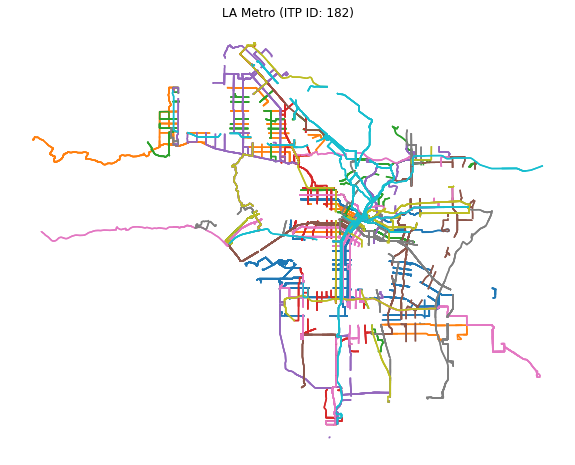

# routes originally for 294: 71
# routes for 294: 70


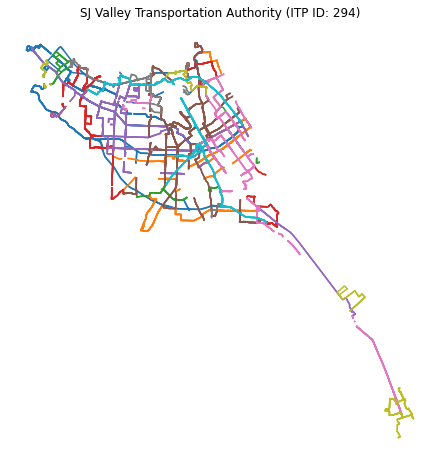

# routes originally for 279: 12
# routes for 279: 12


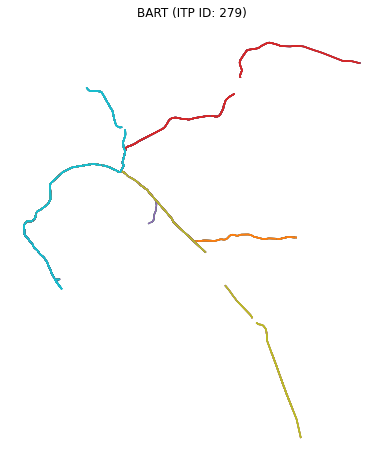

# routes originally for 282: 59
# routes for 282: 59


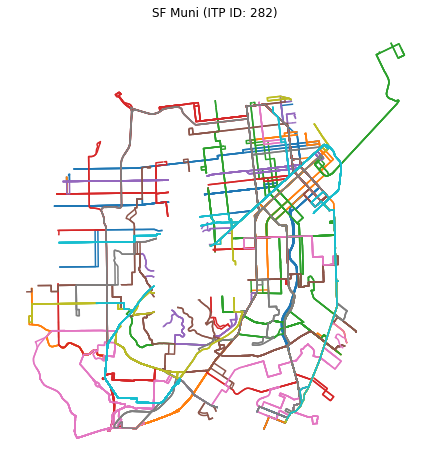

# routes originally for 278: 109
# routes for 278: 108


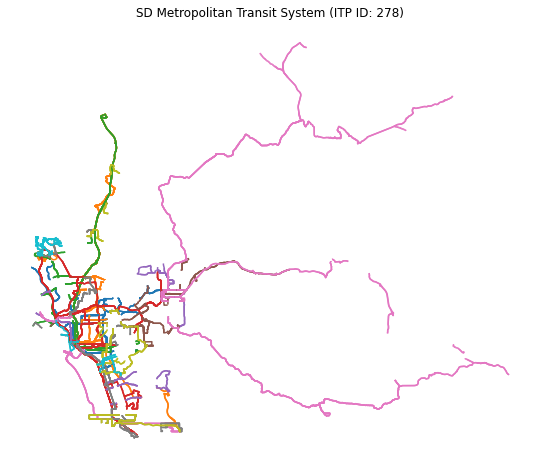

In [4]:
import matplotlib.pyplot as plt

MAP_ME = {
    182: "LA Metro", 
    294: "SJ Valley Transportation Authority", 
    279: "BART", 
    282: "SF Muni",
    278: "SD Metropolitan Transit System", 
}

for i, name in MAP_ME.items():
    subset_df = gdf[gdf.itp_id==i]
    print(f"# routes originally for {i}: {transit_routes[transit_routes.itp_id==i].route_id.nunique()}")
    print(f"# routes for {i}: {subset_df.route_id.nunique()}")
    
    
    fig, ax = plt.subplots(figsize  = (12, 8))
    subset_df.plot(column="route_id",  
                         ax = ax)
    ax.set_axis_off()
    plt.title(f"{name} (ITP ID: {i})")
    display(fig)
    plt.close()

In [5]:
gdf.pct_highway.describe()

count    47396.000000
mean         0.647700
std          3.915224
min          0.000017
25%          0.066727
50%          0.150303
75%          0.417973
max        530.880377
Name: pct_highway, dtype: float64

In [6]:
gdf[gdf.pct_highway > 100]

,itp_id,shape_id,route_id,route_length,Route,County,District,RouteType,NB,SB,EB,WB,highway_length,geometry,pct_route,pct_highway
20916,13,None,37329,1.054695e+09,275,SAC,3,State,0,0,1,1,319.370776,"MULTILINESTRING ((5553863.501 3503999.243, 555...",0.000161,530.880377
21052,372,None,3b108a90-2b16-4dbb-9831-fb13556d15ac,1.356113e+06,275,SAC,3,State,0,0,1,1,319.370776,"MULTILINESTRING ((5562120.764 3506871.250, 555...",0.036373,154.448506
21057,372,None,e38c81ff-f582-4053-b79a-b5831ff0a9c7,2.264167e+06,275,SAC,3,State,0,0,1,1,319.370776,"MULTILINESTRING ((5562120.828 3506871.517, 555...",0.019083,135.289261


In [7]:
gdf[(gdf.pct_highway > 1.0) & (gdf.itp_id==182) & (gdf.County=="LA")
    & (gdf.Route==110)
   ][["route_id", "route_length", "highway_length",
      "geometry", "pct_route", "pct_highway"]]

,route_id,route_length,highway_length,geometry,pct_route,pct_highway
18172,910-13153,203257.376049,125191.103899,"MULTILINESTRING ((6491357.376 1842079.806, 649...",0.691628,1.122911
18175,910-13153,206333.820355,125191.103899,"LINESTRING (6474114.722 1725182.990, 6474116.0...",0.682162,1.124305
18784,804,163016.234449,38787.994447,"LINESTRING (6490429.325 1842121.250, 6490433.4...",0.300734,1.263908
18785,804,163045.012609,38787.994447,"LINESTRING (6516812.703 1874090.643, 6516812.5...",0.300811,1.264456


In [8]:
check_id = [182]
#check_shape = ["100713_DEC21"]
check_highway = [10]

def subset_data(df, itp_id, route_id):
    subset_df = df[(df.itp_id.isin(itp_id) &
                   #(df.shape_id.isin(shape_id) & 
                   (df.Route.isin(route_id)))].reset_index(drop=True)
    
    return subset_df

subset = subset_data(gdf, check_id, check_highway)